# IMPORTS

In [1]:
import tensorflow as tf
import datetime
import time
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import os
import generate_labels_text_file
from collections import Counter
from random import shuffle, randint, seed
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.framework import graph_util
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
%matplotlib inline

100%|████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<?, ?it/s]


In [2]:
print(f'OpenCV version: {cv2.__version__}')
print(f'Tensorflow version: {tf.__version__}')

OpenCV version: 4.1.1
Tensorflow version: 2.0.0


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# PREPROCESSING

In [4]:
# Check what folder to use for training and testing images
# CHISOM_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/train'
#CHISOM_TEST_DIR = 'C:/Users/chiso/MEGA/data/test'
CHISOM_ALIGNED_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/aligned_train'
CHISOM_ALIGNED_TEST_DIR = 'C:/Users/chiso/MEGA/data/aligned_test'

# YISI_TRAIN_DIR = 'E:/MegaSync/data/train'
#YISI_TEST_DIR = 'E:/MegaSync/data/test'
YISI_ALIGNED_TRAIN_DIR = 'E:/MegaSync/data/aligned_train'
YISI_ALIGNED_TEST_DIR = 'E:/MegaSync/data/aligned_test'


def get_directories():
    if os.path.exists(CHISOM_ALIGNED_TRAIN_DIR) and os.path.exists(CHISOM_ALIGNED_TEST_DIR):
        return CHISOM_ALIGNED_TRAIN_DIR, CHISOM_ALIGNED_TEST_DIR
    else:
        return YISI_ALIGNED_TRAIN_DIR, YISI_ALIGNED_TEST_DIR


### Useful Parameters

In [5]:
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR = get_directories()
IMG_SIZE = 100
LR = 1e-3
MODEL_PATH = f'models/{DATE}/'
MODEL_NAME = 'ImageClassifier-keras-5-Conv-Layer-{}.model'.format(int(time.time()))
TENSORBOARD = TensorBoard(log_dir=f'logs\\{MODEL_NAME}') 
NUM_CLASSES = len(next(os.walk(ALIGNED_TRAIN_DIR))[1])
NUM_CLASSES, IMG_SIZE

(153, 100)

In [6]:
ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR

('E:/MegaSync/data/aligned_train', 'E:/MegaSync/data/aligned_test')

### Walkthrough of Subfolders in Train Directory:

In [7]:
# Only the root
ROOTS = next(os.walk(ALIGNED_TRAIN_DIR))[0]
print(f"Roots = {ROOTS}")

Roots = E:/MegaSync/data/aligned_train


In [8]:
# Only the directories
DIRS = next(os.walk(ALIGNED_TRAIN_DIR))[1]
DIRS

['Abella Danger',
 'Abigail Mac',
 'Agatha Vega',
 'Aiden Starr',
 'Aidra Fox',
 'Alecia Fox',
 'Aletta Ocean',
 'Alice Romain',
 'Alina Li',
 'Alina Lopez',
 'Allie Haze',
 'Ally Milano',
 'Alyssia Kent',
 'Amirah Adara',
 'Ana Foxx',
 'Ana Rose',
 'Andriana Chechik',
 'Angel Princess',
 'Angela Sommers',
 'Anita Dark',
 'Ariella Ferrera',
 'Audrey Bitoni',
 'Ava Addams',
 'Bella Milano',
 'Blake Bartelli',
 'Bobbi Star',
 'Brandi Love',
 'Bree Daniels',
 'Brenda James',
 'Bridgette B',
 'Cameron Canela',
 'Cassidy Klein',
 'Catarina Petrov',
 'Chastity Lynn',
 'Cherie De Ville',
 'Chloe Lacourt',
 'Christy Mack',
 'Dana DeArmond',
 'Dana Weyron',
 'Dani Daniels',
 'Deauxma',
 'Dee Williams',
 'Dia Zerva',
 'Diana Ladonna',
 'Elexis Monroe',
 'Emily Addison',
 'Emily Willis',
 'Emma Hix',
 'Eva Notty',
 'Evelina Darling',
 'Evelyn Lin',
 'Gianna Dior',
 'Gina Valentina',
 'India Summer',
 'Isabelle Deltore',
 'Jade Jantzen',
 'Janet Mason',
 'Jelena Jensen',
 'Jenna Sativa',
 'Jessa R

In [9]:
# Only the files
"""for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):
    for name in files:
        print(name.split('.')[0]) # filters the file name by file extension and the copy_number
        
"""

"for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):\n    for name in files:\n        print(name.split('.')[0]) # filters the file name by file extension and the copy_number\n        \n"

### One-Hot Encoding

In [10]:
LABELS = next(os.walk(ALIGNED_TRAIN_DIR))[1] # all the class labels (pornstar names) to be used
LABELS_2D = np.reshape(LABELS, (-1, 1)) # reshapes array from 1D to 2D array
mlb = MultiLabelBinarizer()
encoded_labels = np.array(mlb.fit_transform(LABELS_2D))
# dict(zip(LABELS.flatten(), encoded_labels))

In [11]:
# img.split('.')[0].split('(')[0]  # filters the file name by file extension and the copy_number
"""
Labelled training data
"""
def create_train_data():
    training_data = []
    # iterate over each image-class (subfolder) in training directory
    for folder in tqdm(os.listdir(ALIGNED_TRAIN_DIR)):
        full_path = f'{ALIGNED_TRAIN_DIR}/{folder}'
        # iterate over each image in each subfolder
        for img in os.listdir(full_path):
            ##### !python align_images.py raw_images/ aligned_images/ --output_size=1048
            img_name = str(folder)  # the sub-folder is used as the image name for each image
            img_name = img_name.strip() # removes any leading and trailing whitespaces from the img name
            label = mlb.transform([[img_name]]) # encodes the label of the image using MultiLabelBinarizer
            label = label.flatten()  # converts encoded label from 2D to 1D array
            # print(f'Image: {img} - Encoding:{label}')
            path = os.path.join(full_path, img)  # full path of the image
            # feature extraction
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            img = tf.cast(img, tf.float32) # change data type of image to float32
            training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [12]:
"""
Unlabelled test data
"""
def process_test_data():
    img_ids = list(range(len(os.listdir(ALIGNED_TEST_DIR)))) # generates list of ID numbers
    shuffle(img_ids) # randomly assorted
    img_ids = iter(img_ids) 
    testing_data = [] 
    for img in tqdm(os.listdir(ALIGNED_TEST_DIR)):
        path = os.path.join(ALIGNED_TEST_DIR, img)
        img_num = next(img_ids)
        print(f"ID: {img_num} \t- Image: {img}")
        # feature extraction
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32)
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data     

### Generate Training and Testing data

In [13]:
# train_data = create_train_data()
# test_data = process_test_data()
# if train/test data already exists
train_data = np.load('train_data.npy', allow_pickle=True)
test_data = np.load('test_data.npy', allow_pickle=True)

In [14]:
print(len(train_data))
print(len(test_data))

14114
62


# BUILDING THE MODEL

### Implementation of Convoluted Neural Network

In [15]:
def create_cnn_model():
    # tf.reset_default_graph()
    model = Sequential()
    input_shape = (IMG_SIZE, IMG_SIZE, 1)
    
    # INPUT LAYER
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # HIDDEN LAYER 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # HIDDEN LAYER 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 4
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # Fully Connected
    model.add(Flatten()) # converts the 3D feature maps to 1D feature vectors
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # reduces overfitting

    # OUTPUT LAYER
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# TRAINING THE NETWORK

### Cross Validation Train/Test Split

In [16]:
ratio = int(round(len(train_data), -1) * 0.2)
ratio

2822

In [17]:
train = train_data[:-ratio] # sample train data
test = train_data[-ratio:]

In [18]:
train_X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # train features (images)
train_Y = np.array([i[1] for i in train]) # train labels

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # test features (images)
test_Y = np.array([i[1] for i in test]) # test labels

### Feature Scaling (Normalization)

In [19]:
# Have to divide by 255 
train_X = train_X/255.0
test_X = test_X/255.0

In [20]:
print(f"train data: {train_X.shape}")
print(f"train labels: {train_Y.shape}")
print(f"test data: {test_X.shape}")
print(f"test labels: {test_Y.shape}")

train data: (11292, 100, 100, 1)
train labels: (11292, 153)
test data: (2822, 100, 100, 1)
test labels: (2822, 153)


### Frequency distribution of classes being used in "test data"

In [21]:
enc = []
for img in test:
    enc.append(img[1])
    
enc = np.array(enc)
test_labels = mlb.inverse_transform(enc)
c = Counter(test_labels)
c

Counter({('Riley Star',): 37,
         ('Ally Milano',): 26,
         ('India Summer',): 11,
         ('Gina Valentina',): 30,
         ('Peta Jensen',): 18,
         ('Romi Rain',): 17,
         ('Nelly Kent',): 19,
         ('Bella Milano',): 18,
         ('Sammie Rhodes',): 8,
         ('Jelena Jensen',): 23,
         ('Diana Ladonna',): 5,
         ('Lena Paul',): 21,
         ('Kristen Scott',): 19,
         ('Aidra Fox',): 16,
         ('Emma Hix',): 19,
         ('Lea Guerlin',): 15,
         ('Alina Lopez',): 11,
         ('Jessica Bangkok',): 21,
         ('Alice Romain',): 29,
         ('Karter Foxx',): 26,
         ('Lena Love',): 30,
         ('Sarah Banks',): 18,
         ('Agatha Vega',): 21,
         ('Susy Gala',): 12,
         ('Alina Li',): 18,
         ('Lola Krit',): 28,
         ('Sinn Sage',): 20,
         ('Cassidy Klein',): 19,
         ('Tanya Tate',): 20,
         ('Kimmy Granger',): 24,
         ('Rachel Starr',): 24,
         ('Angela Sommers',): 16,
       

In [24]:
MODEL = create_cnn_model()
MODEL.summary()
history = MODEL.fit(train_X, train_Y, batch_size=32, epochs=100, validation_data=(test_X, test_Y), verbose=2, callbacks=[TENSORBOARD])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        1

Epoch 45/100
11292/11292 - 12s - loss: 0.0501 - accuracy: 0.9868 - val_loss: 1.9673 - val_accuracy: 0.7704
Epoch 46/100
11292/11292 - 12s - loss: 0.0637 - accuracy: 0.9840 - val_loss: 1.3916 - val_accuracy: 0.8381
Epoch 47/100
11292/11292 - 12s - loss: 0.0693 - accuracy: 0.9820 - val_loss: 1.5083 - val_accuracy: 0.8370
Epoch 48/100
11292/11292 - 12s - loss: 0.0546 - accuracy: 0.9845 - val_loss: 1.3914 - val_accuracy: 0.8349
Epoch 49/100
11292/11292 - 11s - loss: 0.0538 - accuracy: 0.9866 - val_loss: 1.8496 - val_accuracy: 0.8072
Epoch 50/100
11292/11292 - 12s - loss: 0.0756 - accuracy: 0.9825 - val_loss: 1.4662 - val_accuracy: 0.8288
Epoch 51/100
11292/11292 - 11s - loss: 0.0679 - accuracy: 0.9835 - val_loss: 1.4377 - val_accuracy: 0.8317
Epoch 52/100
11292/11292 - 11s - loss: 0.0496 - accuracy: 0.9863 - val_loss: 1.7365 - val_accuracy: 0.8016
Epoch 53/100
11292/11292 - 11s - loss: 0.0608 - accuracy: 0.9843 - val_loss: 1.8271 - val_accuracy: 0.8175
Epoch 54/100
11292/11292 - 11s - loss

## Saving Model

In [25]:
MODEL.save(f'{MODEL_PATH}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/18-Dec-2019/assets


## Load Model

In [26]:
#date = datetime.date(2019, 12, 17).strftime('%d-%b-%Y')
#model_path = f'models/{date}/'
#MODEL = tf.keras.models.load_model(f'{model_path}')
# MODEL =  tf.keras.models.load_model(f'{MODEL_PATH}')

### Convert model to TensorFlow Lite format

In [27]:
"""converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)"""

'converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)\ntflite_model = converter.convert()\nopen("converted_model.tflite", "wb").write(tflite_model)'

### Validate the Converted TFLite model

In [28]:
"""# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite") 
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details() 
output_details = interpreter.get_output_details()
print(input_details)

# Test model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(test_X[1].reshape(1,100,100,1), dtype=np.float32) 
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index']) 
print(output_data)"""

'# Load TFLite model and allocate tensors.\ninterpreter = tf.lite.Interpreter(model_path="converted_model.tflite") \ninterpreter.allocate_tensors()\n\n# Get input and output tensors\ninput_details = interpreter.get_input_details() \noutput_details = interpreter.get_output_details()\nprint(input_details)\n\n# Test model on random input data\ninput_shape = input_details[0][\'shape\']\ninput_data = np.array(test_X[1].reshape(1,100,100,1), dtype=np.float32) \ninterpreter.set_tensor(input_details[0][\'index\'], input_data)\ninterpreter.invoke()\n\noutput_data = interpreter.get_tensor(output_details[0][\'index\']) \nprint(output_data)'

## Generate Labels Text File

In [29]:
%run generate_labels_text_file.py

100%|████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 153633.83it/s]


# RESULTS

### Graph Plot of Predicted Classes

Image ID: 4	 | Prediction: Aiden Starr
Image ID: 20	 | Prediction: Alecia Fox
Image ID: 45	 | Prediction: Alice Romain
Image ID: 43	 | Prediction: Allie Haze
Image ID: 35	 | Prediction: Alyssia Kent
Image ID: 59	 | Prediction: Osa Lovely
Image ID: 23	 | Prediction: Andriana Chechik
Image ID: 47	 | Prediction: Anita Dark
Image ID: 7	 | Prediction: Alyssia Kent
Image ID: 50	 | Prediction: Blake Bartelli
Image ID: 0	 | Prediction: Bridgette B
Image ID: 37	 | Prediction: Catarina Petrov
Image ID: 18	 | Prediction: Cherie De Ville
Image ID: 12	 | Prediction: Riley Steele
Image ID: 56	 | Prediction: Dana DeArmond
Image ID: 53	 | Prediction: Deauxma
Image ID: 32	 | Prediction: Dee Williams
Image ID: 10	 | Prediction: Emily Addison
Image ID: 21	 | Prediction: Emily Willis
Image ID: 16	 | Prediction: Lana Rhoades
Image ID: 15	 | Prediction: Gianna Dior
Image ID: 51	 | Prediction: Gina Valentina
Image ID: 52	 | Prediction: Andriana Chechik
Image ID: 42	 | Prediction: Jade Jantzen
Image ID: 11	 |

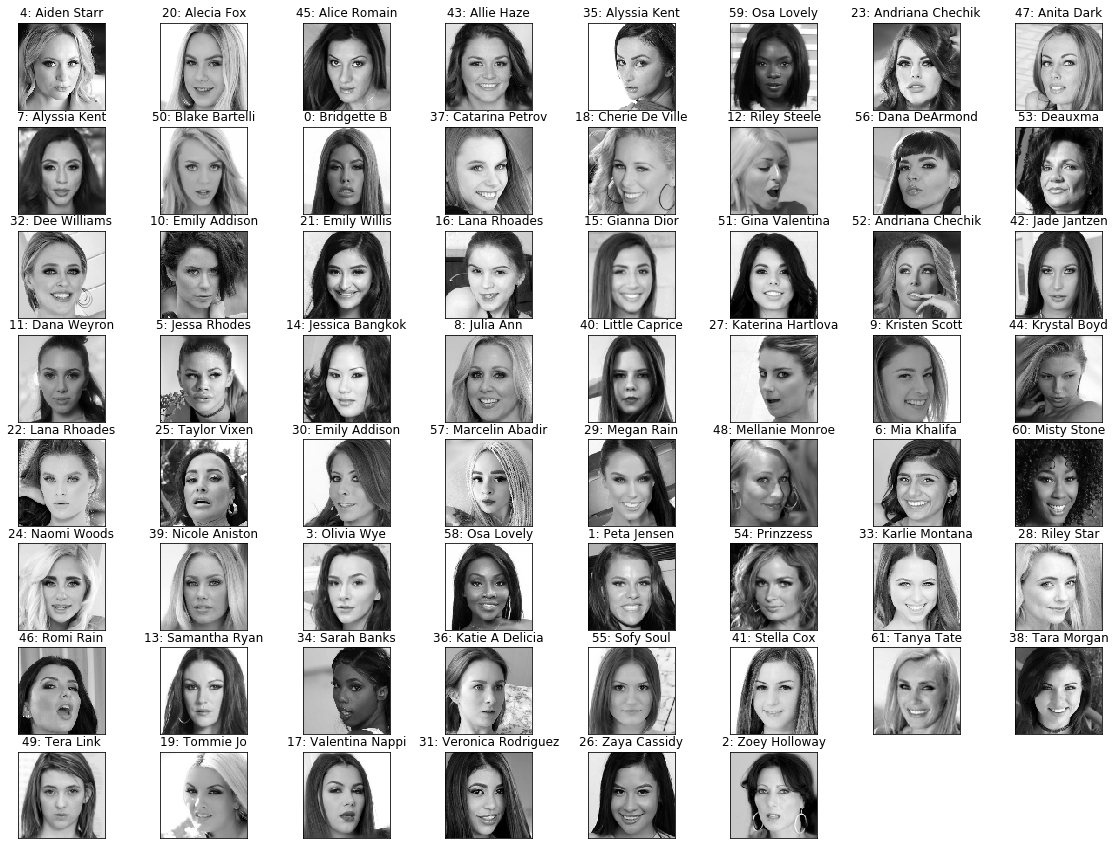

In [30]:
CLASS_INDEX = dict(zip([np.argmax(x) for x in encoded_labels], LABELS))
test_data = np.load('test_data.npy', allow_pickle=True)
fig = plt.figure(figsize=(20,15))
RESULTS = {cls: [] for cls in LABELS}
IMAGE_IDs = []

# iterate over each image in test_sample
# get the model's class prediction of the image
for num, data in enumerate(test_data):
    data[0] = data[0] / 255.0
    img_data = data[0]
    img_num = data[1]
    y = fig.add_subplot(8, 8, num + 1)
    orig = img_data
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    model_out = MODEL.predict([data]).flatten()
    index = np.argmax(model_out)
    # generate output dictionary
    RESULTS = {LABELS[i]: RESULTS.get(LABELS[i]) + [model_out[i]] for i in range(NUM_CLASSES)}
    IMAGE_IDs.append(img_num)
    
    # cross-reference the predicted class-index to its class-label (for each test image)
    class_label = CLASS_INDEX.get(index, 'Invalid class!')
    print(f"Image ID: {img_num}\t | Prediction: {class_label}")

    y.imshow(orig, cmap='gray')
    plt.title(f'{img_num}: {class_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('Class Results')

In [31]:
IMAGES_NAMES = [img.split('.')[0] for img in next(os.walk(ALIGNED_TEST_DIR))[2]]

### Tabulated Prediction Probabilities

In [32]:
# Creates a HeatMap using the seaborn library
cm = sns.light_palette("red", as_cmap=True)
df = pd.DataFrame.from_dict(RESULTS, orient='index', columns=IMAGE_IDs)
df.style.\
    format("{:.2%}").\
    set_caption('Confidence Values')\
    .background_gradient(cmap=cm)

### Get Top 5 results for Test Image

In [33]:
"""
Re-structures the results dictionary so that each class_label points to another dictionary {k, v}
where k = the Image_Id number and v = the confidence value
"""

def gen_results(results):
    my_dict = {}
    for cls in LABELS:
        probs = iter(results[cls])
        my_dict.update({cls: {}})
        for k in IMAGE_IDs:
            my_dict[cls][int(k)] = next(probs)

    return my_dict

In [34]:
def get_top5(results, ID=1):
    results = gen_results(results)
    probs = np.array([(results[k][ID]) for k in results])
    # print(f'Reverse: {(-probs).argsort()} - {sorted(probs, reverse=True)}')
    indices = (-probs).argsort()[:5] # sorts probabilities (largest - smallest) + returns their corresponding array indices
    top_5 = [CLASS_INDEX.get(i) for i in indices]
    return top_5

In [35]:
Image_ID = 3
TOP_5 = get_top5(RESULTS, Image_ID)
TOP_5

['Olivia Wye', 'Dana DeArmond', 'Sheri Vi', 'Sinn Sage', 'Serpente Edita']

# Get Overall Accuracy

In [36]:
def get_overall_accuracy(results):
    i = 0
    num_correct = 0
    total = len(test_data) # total number of images
    keys = results.keys()
    class_labels = []
    
    # loop through each image  in results and store its's classification scores in a list
    # 
    for id in IMAGE_IDs: # loop through each image ID
        predictions = []
        for key in list(keys): # for each model in the results dictionary
            prob = results[key].get(id) # get the associated confidence value for that classification pair
            predictions.append(prob)
        max_index = np.argmax(predictions) # index containing the max confidence value
        label = CLASS_INDEX.get(max_index, 'Invalid class!') # find label that corresponds with that index
        class_labels.append(label) # add label to list of class labels 
    
    for img in os.listdir(ALIGNED_TEST_DIR):
        img = img.split('.')[0].strip() # gets the class name of the image file
        if img == class_labels[i]: # check if file name (actual) is equal to predicted label (predicted)
            num_correct += 1
        # print(f"Image name: {img} - predicted label: {class_labels[i]}")
        i += 1 
        
        
    accuracy = round((num_correct / total) * 100, 2)
    return f'{accuracy}%'

# Overall Accuracy

In [37]:
get_overall_accuracy(gen_results(RESULTS))

'82.26%'

# Relative Accuracy

In [ ]:
def get_relative_accuracy():
    num_correct = 0
    total = len(test_data) # total number of images
    ids = iter(IMAGE_IDs) 
    class_labels = []
    
    for img in os.listdir(ALIGNED_TEST_DIR): # for each test image
        ID = next(ids)
        img = img.split('.')[0].strip() # gets the class name of the image file
        top_5 = get_top5(RESULTS, ID) # gets the top_5 models for each Image ID
        if img in top_5: # if image is found within top 5 matches, add 1 to num correct
            num_correct += 1 
        
    accuracy = round((num_correct / total) * 100, 2)
    return f'{accuracy}%'

In [ ]:
get_relative_accuracy()

In [39]:
get_relative_accuracy()

'93.55%'